# Dự đoán giá chứng khoán trong 30 ngày tiếp theo của Amazon
---

## 1. Import thư viện
---

In [1]:
import pandas as pd 

# phải cài cái này để load dữ liệu về
from pandas_datareader.data import DataReader

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# vẽ biểu đồ cho ngầu 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# xử lý thời gian 
from datetime import datetime

# keras for LSTM 
# phải cài cái này 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

## 2. Download data
---

In [2]:
df = DataReader('AMZN', data_source='yahoo', start='2009-01-01', end='2019-12-31')
df
# df = pd.read_csv('AMZN.csv')
# df = df.set_index('Date')
# df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2008-12-31,51.689999,49.910000,50.740002,51.279999,7792200,51.279999
2009-01-02,54.529999,51.070000,51.349998,54.360001,7296400,54.360001
2009-01-05,55.740002,53.029999,55.730000,54.060001,9509800,54.060001
2009-01-06,58.220001,53.750000,54.549999,57.360001,11080100,57.360001
2009-01-07,56.950001,55.349998,56.290001,56.200001,7942700,56.200001
...,...,...,...,...,...,...
2019-12-24,1795.569946,1787.579956,1793.810059,1789.209961,881300,1789.209961
2019-12-26,1870.459961,1799.500000,1801.010010,1868.770020,6005400,1868.770020
2019-12-27,1901.400024,1866.010010,1882.920044,1869.800049,6186600,1869.800049


In [3]:
df.shape

(2769, 6)

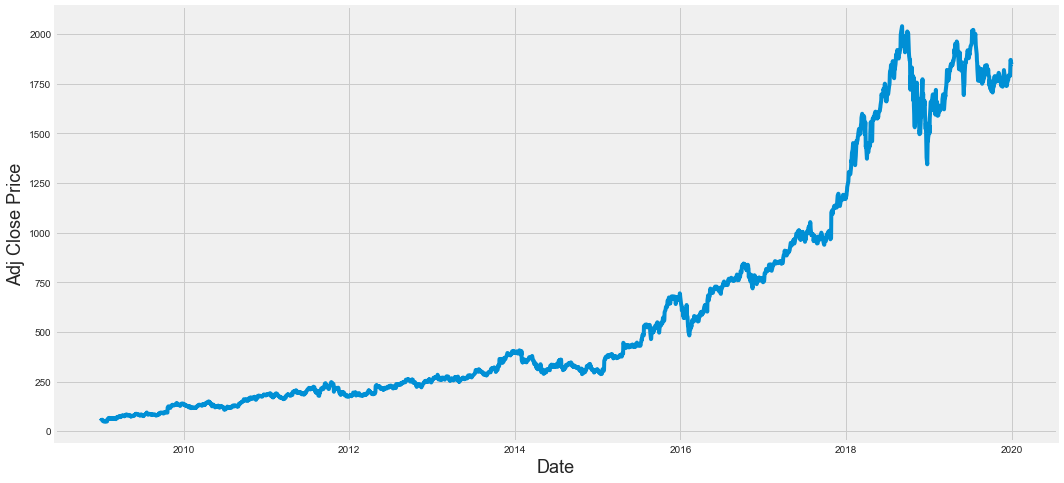

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price', fontsize=18)
plt.show()

## 3. Chia tập dữ liệu để làm việc
---

In [5]:
def splitDataset(df):
    length = df.shape[0]
    train_df = df[:length - 30]
    test_df = df[length - 30:]
    return train_df, test_df

train_df, test_df = splitDataset(df)

train_df.shape, test_df.shape

((2739, 6), (30, 6))

## 4. Tiền xử lý tập train và tạo `preprocess_pipeline`
---

In [6]:
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Adj Close'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(2739, 1)

In [7]:
# scale dữ liệu train
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(real_train_df)

def reshapeForModel(scaled_train_data):
    return scaled_train_data.reshape((-1,))

scaled_train_data = reshapeForModel(scaled_train_data)
scaled_train_data.shape

(2739,)

In [8]:
# tạo dữ liệu train_X và train_y
def createTrainX_y(scaled_train_data, time_steps=1500, out_length=30):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1], 1)), train_y

train_X, train_y = createTrainX_y(scaled_train_data)
train_X.shape, train_y.shape

((1210, 1500, 1), (1210, 30))

In [9]:
preprocess_pipeline = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y)),
])

train_X, train_y = preprocess_pipeline.fit_transform(train_df)
train_X.shape, train_y.shape

((1210, 1500, 1), (1210, 30))

## 5. Tạo model
---

In [10]:
# Tạo model 
def createModel(train_X, time_steps=1500, out_length=30):
    model = Sequential()
    model.add(LSTM(500, activation='tanh', return_sequences=False, input_shape=(train_X.shape[1], 1)))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

## 6. `fit` model với tập train và predict tập test 
---

In [11]:
# build model 
model = createModel(train_X)
model.summary()
model.fit(train_X, train_y, batch_size=1, epochs=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500)               1004000   
_________________________________________________________________
dense (Dense)                (None, 30)                15030     
Total params: 1,019,030
Trainable params: 1,019,030
Non-trainable params: 0
_________________________________________________________________
1210/1210 [==============================] - 4190s 3s/step - loss: 0.0148


- Để có thể dự đoán được 30 giá trị trong tập test, ta cần 1500 giá trị cuối cùng của tập train 
- Do đó, cần tạo mảng input chứa các dữ liệu nêu trên để có thể dự đoán

In [12]:
# tạo tập test_inputs
test_inputs = df[len(df) - len(test_df) - 1500 :]
test_X, test_y = preprocess_pipeline.transform(test_inputs)
test_X.shape, test_y.shape

((1, 1500, 1), (1, 30))

In [13]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
pred_test = model.predict(test_X)
pred_test = scaler.inverse_transform(pred_test)
print(pred_test[0])
# print('\n\n')
# print(test_y[0])

[1636.0337 1673.9045 1697.085  1689.0288 1695.2114 1656.2637 1665.9924
 1647.2821 1634.2445 1632.5529 1611.2535 1634.5912 1630.2859 1635.9204
 1646.0625 1652.3138 1661.9344 1665.11   1664.5679 1700.9468 1693.0901
 1707.9769 1706.7222 1706.2235 1711.8291 1722.9093 1721.9392 1706.1421
 1717.1569 1681.6971]


In [14]:
# # tạo dữ liệu test 
# test_inputs = df[len(df) - len(test_df) - 60:len(df) - len(test_df) + 1]
# test_X, test_y = preprocess_pipeline.transform(test_inputs)

# # dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu 
# pred_test = model.predict(test_X)
# pred_test = preprocess_pipeline.inverse_transform(pred_test)
# pred_test.shape

<ipython-input-15-2f68462fc84f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = pred_test[0]


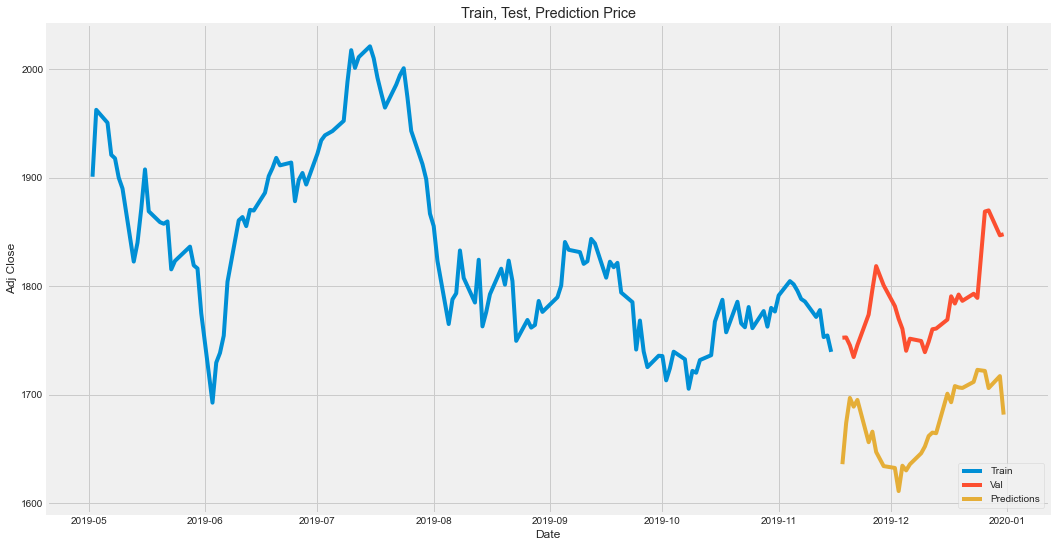

In [15]:
# vẽ đồ thị phần train, test và predict 
length = df.shape[0]
train = df[2600:length - 30]
test = df[length - 30:]
test['Predictions'] = pred_test[0]

plt.figure(figsize=(16,9))
plt.title('Train, Test, Prediction Price')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [16]:
mse = np.sqrt(np.mean((test['Adj Close'] - test['Predictions']) ** 2))
print(mse)

113.32358794349999


In [17]:
test

,High,Low,Open,Close,Volume,Adj Close,Predictions
Date,,,,,,,
2019-11-18,1753.699951,1722.709961,1738.300049,1752.530029,2839500,1752.530029,1636.033691
2019-11-19,1760.680054,1743.030029,1756.989990,1752.790039,2270800,1752.790039,1673.904541
2019-11-20,1762.520020,1734.119995,1749.140015,1745.530029,2790000,1745.530029,1697.084961
2019-11-21,1746.869995,1730.359985,1743.000000,1734.709961,2662900,1734.709961,1689.028809
2019-11-22,1746.430054,1731.000000,1739.020020,1745.719971,2479100,1745.719971,1695.211426
2019-11-25,1777.420044,1753.239990,1753.250000,1773.839966,3486200,1773.839966,1656.263672
2019-11-26,1797.030029,1778.349976,1779.920044,1796.939941,3181200,1796.939941,1665.992432
2019-11-27,1824.500000,1797.310059,1801.000000,1818.510010,3025600,1818.510010,1647.282104
2019-11-29,1824.689941,1800.790039,1817.780029,1800.800049,1923400,1800.800049,1634.244507
